In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS, HMC
from functools import partial
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import logging
from jax.scipy.linalg import cholesky

# Set logging level to INFO to display progress bar messages
logger = logging.getLogger()
logger.setLevel(logging.INFO)
from jax import config
#check that Jax is using the GPU 
config.update("jax_enable_x64", True)

In [2]:
params_array = np.load("params_array_from_lhc_new.npy")[:1000, :80]
knots = np.load("/cluster/work/refregier/alexree/local_packages/train_pybird_emulators/src/train_pybird_emulators/data/knots_data/final_knots_80.npy")

In [3]:
params_array.shape 

(1000, 80)

In [4]:
params_mean = jnp.mean(params_array, axis=0)

2024-10-14 07:12:36.421757: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
params_mean.shape 

(80,)

In [6]:
# Modify the kernel function to have different amplitudes and lengthscales at each knot
# Define the squared exponential kernel function
def squared_exponential_kernel(x1, x2, amplitude, lengthscale):
    sqdist = jnp.sum((x1[:, None] - x2[None, :]) ** 2, axis=-1)
    return amplitude**2 * jnp.exp(-0.5 * sqdist / lengthscale**2)

# Gaussian Process model with a known mean
def gp_model_with_mean(k_array, params_array):
    jitter = 1e-6  # Add a small jitter to avoid numerical instabilities
    n_points = len(k_array)
    
    # Calculate the mean function from the params_array
    params_mean = jnp.mean(params_array, axis=0)  # Mean across realizations (shape: n_points)

    # Define the amplitude and lengthscale for the GP residuals
    amplitude = numpyro.sample('amplitude', dist.LogNormal(0.0, 0.5))
    lengthscale = numpyro.sample('lengthscale', dist.LogNormal(0.0, 0.5))
    
    # Compute the covariance matrix using the squared exponential kernel
    cov = squared_exponential_kernel(k_array, k_array, amplitude, lengthscale) + jitter * jnp.eye(n_points)
    
    # Perform Cholesky decomposition for efficient sampling
    chol_cov = cholesky(cov, lower=True)
    
    # Sample from the GP residuals (these are deviations from the mean)
    standard_normal = numpyro.sample('standard_normal', dist.Normal(0.0, 1.0).expand([n_points]))
    f_residuals = jnp.dot(chol_cov, standard_normal)
    
    # The full function is the mean + GP residuals
    f_samples = params_mean + f_residuals
    
    # Define the likelihood, where we compare the GP samples to the original data
    numpyro.sample('obs', dist.Normal(f_samples, 1e-6), obs=params_array)

In [24]:
# Set up the NUTS sampler and MCMC
nuts_kernel = NUTS(gp_model_with_mean)
mcmc = MCMC(nuts_kernel, num_warmup=200, num_samples=500, num_chains=1)
mcmc.run(jax.random.PRNGKey(1), knots, params_array)

sample: 100%|██████████| 700/700 [06:55<00:00,  1.68it/s, 1023 steps of size 1.11e-14. acc. prob=0.79]


In [25]:
mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
          amplitude      3.23      0.00      3.23      3.23      3.23      4.58      1.22
        lengthscale      0.29      0.00      0.29      0.29      0.29      3.72      1.81
 standard_normal[0]      1.21      0.00      1.21      1.21      1.21      5.36      1.36
 standard_normal[1]      1.17      0.00      1.17      1.17      1.17      5.11      1.00
 standard_normal[2]      1.00      0.00      1.00      1.00      1.00      3.16      2.03
 standard_normal[3]      0.59      0.00      0.59      0.59      0.59      3.07      1.76
 standard_normal[4]      1.86      0.00      1.86      1.86      1.86      6.72      1.28
 standard_normal[5]      0.28      0.00      0.28      0.28      0.28      3.64      1.61
 standard_normal[6]      1.04      0.00      1.04      1.04      1.04      2.79      2.14
 standard_normal[7]     -1.24      0.00     -1.24     -1.24     -1.24      7.77      1.06
 standard

In [26]:

# Generate samples from the trained GP
def generate_new_gp_samples(k_array, mcmc_result, n_samples=50):
    samples = mcmc_result.get_samples()
    
    amplitude_mean = jnp.mean(samples['amplitude'])
    lengthscale_mean = jnp.mean(samples['lengthscale'])
    
    # Recompute the covariance matrix with posterior mean hyperparameters
    cov = squared_exponential_kernel(k_array, k_array, amplitude_mean, lengthscale_mean) + 1e-6 * jnp.eye(len(k_array))
    
    # Cholesky decomposition for efficient sampling
    chol_cov = cholesky(cov, lower=True)
    
    # Sample new standard normal variables
    rng_key = jax.random.PRNGKey(0)
    standard_normal_samples = jax.random.normal(rng_key, (n_samples, len(k_array)))
    
    # Generate new GP samples
    gp_samples = jnp.einsum('ij,rj->ri', chol_cov, standard_normal_samples)
    
    # Add the mean function back
    new_gp_samples = gp_samples + params_mean
    
    return new_gp_samples

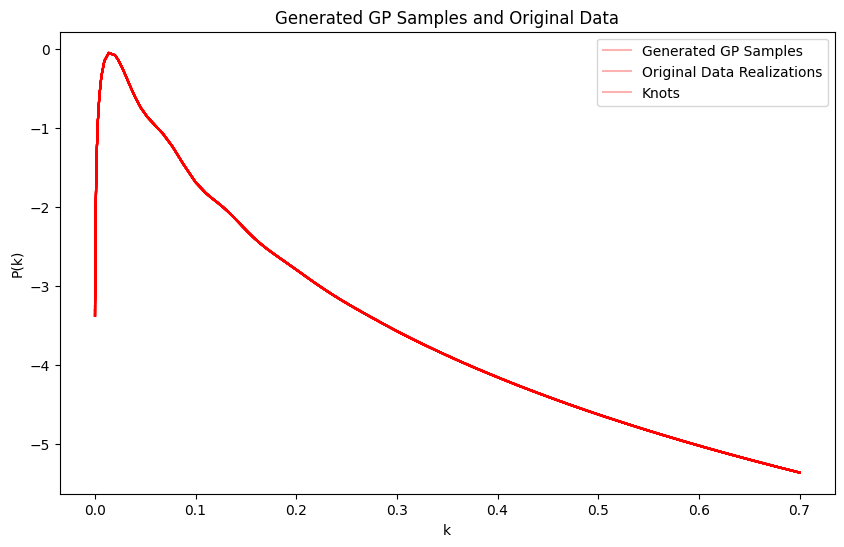

In [30]:
new_samples = generate_new_gp_samples(knots, mcmc)

# Plot the new samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the generated GP samples
for i in range(new_samples.shape[0]):
    plt.plot(knots, new_samples[i, :], color='red', alpha=0.3)

# # Plot the original data for comparison
# for i in range(params_array.shape[0]):
#     plt.plot(knots, jnp.exp(params_array[i, :]), color='blue', alpha=0.1)

# # Add the knot markers
# plt.scatter(knots, jnp.exp(params_array[0, :]), color='black', marker='x', label="Knots", s=50)

# Labels and legend
plt.xlabel('k')
# plt.xscale("log")
# plt.yscale("log")

plt.ylabel('P(k)')

plt.title('Generated GP Samples and Original Data')
plt.legend(["Generated GP Samples", "Original Data Realizations", "Knots"])
plt.show()